# Target: using python and numpy implement a neural network framework.

Node:

+ forward: Function, how to calculate the inputs
+ backwards: Function, how to get the gradients when backpropogation
+ gradients: Mapper, the gradient map the this node of its inputs node
+ inputs: List, the input nodes of this node
+ outputs: List, the output node of this node

## 用面向对象的方式来组织这个框架

1. 构建基类

In [167]:
class Node:
    """
    each node in neural networks will have these attributes and methods.
    """
    def __init__(self, inputs=[]):
        """
        if the node is the operator of "ax+b", the inputs will be x node, and the outputs of this is its successors.
        and the value is "ax+b"
        """
        self.inputs = inputs
        self.value = None
        self.outputs = []
        self.gradients = {}
        
        for node in self.inputs:
            node.outputs.append(self) # build a connection relationship
            
    def forward(self):
        """
        forward propagation. compute the output value based on input nodes and store the value into self.value
        """
        raise NotImplemented
        
    def backward(self):
        """
        back propagation. compute the gradient of each input node and store the value into self.gradients
        """
        raise NotImplemented
        

2. 输入节点类

In [168]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [169]:
import numpy as np
X = np.array([1,2,3])
W = np.array([[1,2],[3,4],[5,6]])
print(X.shape, W.shape)

(3,) (3, 2)


In [170]:
np.dot(X, W) 

array([22, 28])

2. 线性传播节点

In [171]:
class Linear(Node):
    def __init__(self, nodes, weights, bias,name=''):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        self.name = name
        Node.__init__(self, inputs = [nodes, weights, bias]) # inputs = [nodes, weights, bias]
        
    def forward(self):
        """
        compute the wx+b using numpy
        """
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    def backward(self):
        for node in self.outputs:
            # gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost)
            self.gradients[self.b_node] = np.sum(grad_cost*1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [172]:
class Sigmoid(Node):
    def __init__(self, node,name=''):
        Node.__init__(self,[node]) 
        self.x_node = node
        self.name = name
    
    def _sigmoid(self, x):
        return 1.0/(1+np.exp(-x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        self.partial = y*(1-y)
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

In [173]:
class MSE(Node):
    def __init__(self, y_true, y_hat,name=''):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        self.name = ''
        Node.__init__(self, inputs=[y_true, y_hat])
        
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.value = np.mean((y_true_flatten - y_hat_flatten)**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        y_true_flatten = self.y_true_node.value.reshape(-1,1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1,1)
        self.gradients[self.y_true_node] = (2/n)*(y_true_flatten - y_hat_flatten)
        self.gradients[self.y_hat_node] = (-2/n)*(y_true_flatten - y_hat_flatten)

In [174]:
def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的一个list
    for node in topological_sorted_graph:
        node.forward()
    
    for node in topological_sorted_graph[::-1]:
        node.backward()

In [175]:
a=[1,5,4,3,2]
a[::-1]

[2, 3, 4, 5, 1]

In [176]:
a

[1, 5, 4, 3, 2]

In [177]:
def topological_sort(data_with_value):
    feed_dict = data_with_value
    input_nodes = [n for n in feed_dict.keys()]
    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(), 'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in':set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()
        
        if isinstance(n, Input): # 判断n是否属于Input类，考虑继承关系
            n.value = feed_dict[n]
        
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [178]:
def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1*learning_rate * t.gradients[t]

In [179]:
from sklearn.datasets import load_boston
data = load_boston()
X_ = data['data']
y_ = data['target']


# build a graph connection
## 1. build nodes in this graph

In [180]:
X, y = Input(name='X'), Input(name='y') # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

### 2. build connection relationship

In [181]:
linear_output1 = Linear(X, W1, b1,name='linear1')
sigmoid_output1 = Sigmoid(linear_output1,name='sigmoid1')
yhat = Linear(sigmoid_output1, W2, b2,name='yhat')
loss = MSE(y, yhat)

现在只建立三层全连接网络，作业里我们可以把网络变得更复杂

In [182]:
num_feature = X_.shape[1]
num_hidden1 = 10
W1_ = np.random.randn(num_feature, num_hidden1)
b1_ = np.zeros(num_hidden1)

W2_ = np.random.randn(num_hidden1,1)
b2_ = np.zeros(1)

In [183]:
# feed_dict
input_node_with_value = {  
    X: X_,
    y: y_,
    W1: W1_,
    W2: W2_,
    b1: b1_,
    b2: b2_,
}

In [184]:
graph = topological_sort(input_node_with_value)

In [185]:
graph

[Input Node: b1,
 Input Node: W1,
 Input Node: W2,
 Input Node: y,
 Input Node: X,
 Input Node: b2,

In [186]:
from sklearn.utils import resample
np.random.choice(range(100), size=10, replace=True)

array([49, 61, 22, 23, 44, 60, 82, 68, 34, 80])

In [187]:
def run(dictionary):
    return topological_sort(dictionary)

In [188]:
losses = []
epochs = 2000
learning_rate = 1e-3
batch_size = 64
steps_per_epoch = X_.shape[0]//batch_size

for i in range(epochs):
    loss = 0
    for batch in range(steps_per_epoch):
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)
        X.value = X_batch
        y.value = y_batch
    
        training_one_batch(graph)
        sgd_update(trainable_nodes = [W1,W1,b1,b2], learning_rate=learning_rate)
        loss += graph[-1].value
    if i%100==0:
        print('Epoch: {}, loss={:.3f}'.format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Epoch: 1, loss=563.727
Epoch: 101, loss=109.830
Epoch: 201, loss=82.469
Epoch: 301, loss=97.616
Epoch: 401, loss=86.997
Epoch: 501, loss=86.134
Epoch: 601, loss=81.204
Epoch: 701, loss=87.198
Epoch: 801, loss=88.730
Epoch: 901, loss=88.405
Epoch: 1001, loss=90.607
Epoch: 1101, loss=90.099
Epoch: 1201, loss=84.809
Epoch: 1301, loss=78.232
Epoch: 1401, loss=89.074
Epoch: 1501, loss=85.122
Epoch: 1601, loss=87.524
Epoch: 1701, loss=74.207
Epoch: 1801, loss=76.171
Epoch: 1901, loss=88.202


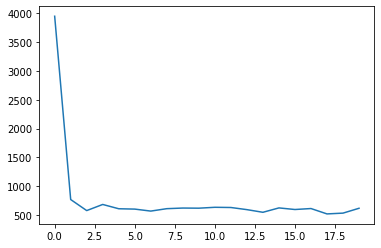

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)

In [195]:
[n.name for n in W2.outputs]

['yhat']

还没整明白：

1. 图拓扑排序；
2. 每个node的self.outputs列表怎么添加元素的，即输入输出关系如何确定